# Goal

The goal here is to write everything with modular code and then conduct experiments that allow us to get ECN networks to work properly on the CityScapes dataset. We will try a few different approaches to improve results:

* Try different architectures, including a two-stage approach, as well as trying to predict residuals rather than the original $y$ labels
* Increasing the receptive field size on the input as well as the output


# Setup

In [15]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_miscl, generator

from scripts import *

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Train a Model on Misclassified Data

In [3]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
model_name = "modular_unet_miscl_weights.h5"
TRAIN_N = 2975
VAL_N = 500

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [4]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True)

In [5]:
miscl_generator = generator_miscl.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians, misclassified_frac=0.75)

In [6]:
history = coarse_model.fit_generator(miscl_generator,
                                     steps_per_epoch= TRAIN_N // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps=VAL_N // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
500
500
2975
2975


743/743 [==============================] - 262s 353ms/step - loss: 0.3040 - dice_coef: 0.8224 - normalized_iou_coef: 0.4841 - hard_normalized_hard_iou_coef: nan - val_loss: 0.4397 - val_dice_coef: 0.7778 - val_normalized_iou_coef: 0.4732 - val_hard_normalized_hard_iou_coef: 0.4770
Epoch 2/5
743/743 [==============================] - 256s 344ms/step - loss: 0.2135 - dice_coef: 0.8792 - normalized_iou_coef: 0.5426 - hard_normalized_hard_iou_coef: nan - val_loss: 0.3077 - val_dice_coef: 0.8515 - val_normalized_iou_coef: 0.5511 - val_hard_normalized_hard_iou_coef: 0.5299
Epoch 3/5
743/743 [==============================] - 257s 345ms/step - loss: 0.1874 - dice_coef: 0.8951 - normalized_iou_coef: 0.5620 - hard_normalized_hard_iou_coef: nan - val_loss: 0.2803 - val_dice_coef: 0.8649 - val_normalized_iou_coef: 0.5648 - val_hard_normalized_hard_iou_coef: 0.5380
Epoch 4/

# View Predictions

Manually view them to confirm that the predictions on the training set are similar to the training labels

2975
2975
2975
2975
0
83929.07805184275 8319.274305363186 5808.921948432922
0.8559189376429194
1
402.54060872411355 303.6539475932465 2639.459390461445
0.12031746711631057
2
31245.466816664673 6871.986198312816 7046.53318464756
0.6918226101336483

0
84953.0 5120.0 4785.0
0.8955807628244323
1
1.0 0.0 3041.0
0.0003287310979618672
2
34610.0 6388.0 3682.0
0.7746195165622203

0
61651.68040637672 14890.788424337283 3929.3195917010307
0.7661278768001624
1
3902.233461471973 494.36703237095213 21214.766532838345
0.15236334153529274
2
33657.578183273785 16475.352358345357 6716.421818256378
0.5920485772680398

0
62027.0 11128.0 3554.0
0.8086013375223247
1
0.0 0.0 25117.0
0.0
2
36905.0 21012.0 3469.0
0.6011957123774151

0
57863.53263919428 14482.383055349812 4564.467359900475
0.7523500773391404
1
5145.015896404977 704.2890726705361 26016.98410487175
0.1614563868565216
2
30670.14869859256 22206.63053271565 6811.851301312447
0.5138356907322728

0
57946.0 10129.0 4482.0
0.7986272861336604
1
0.0 0.0 3

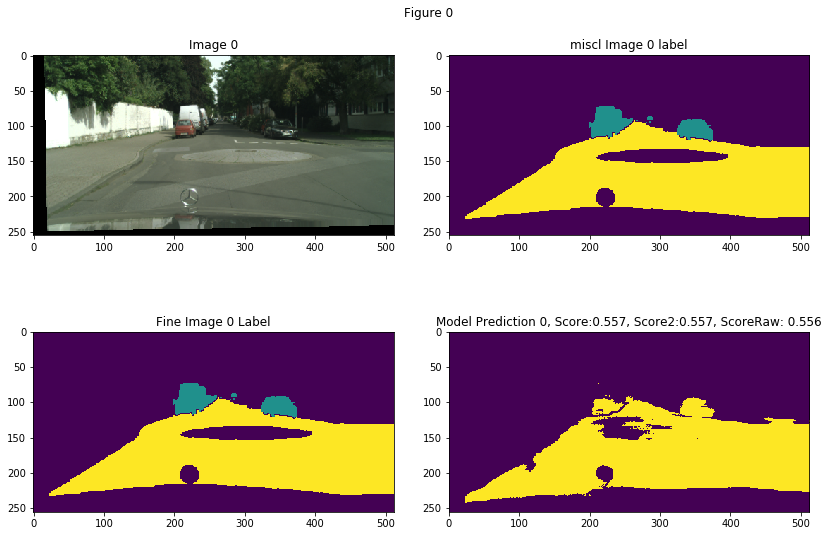

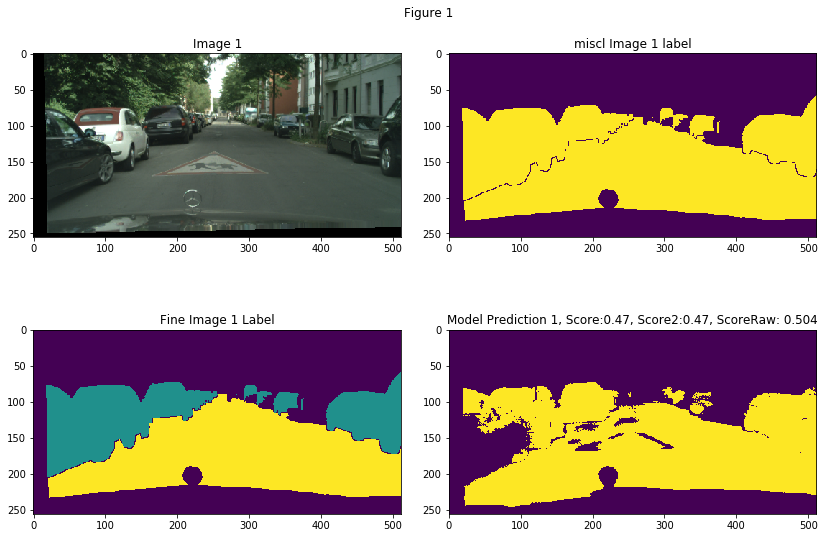

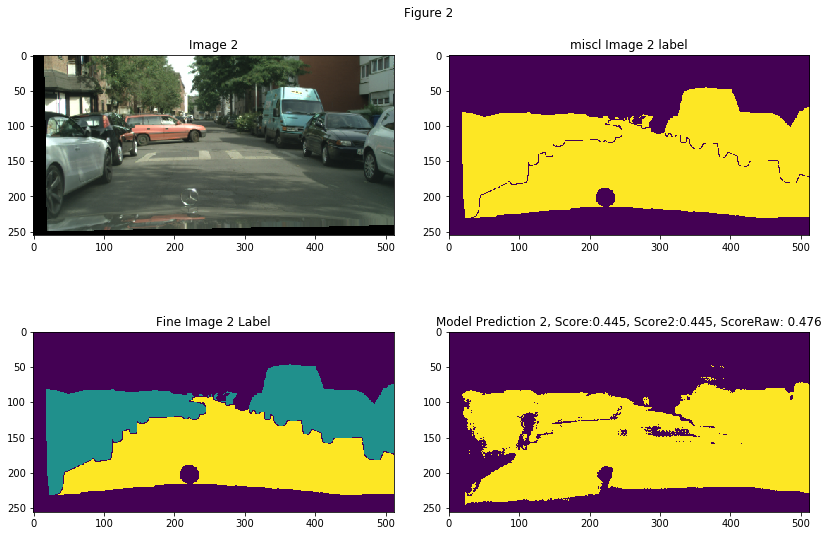

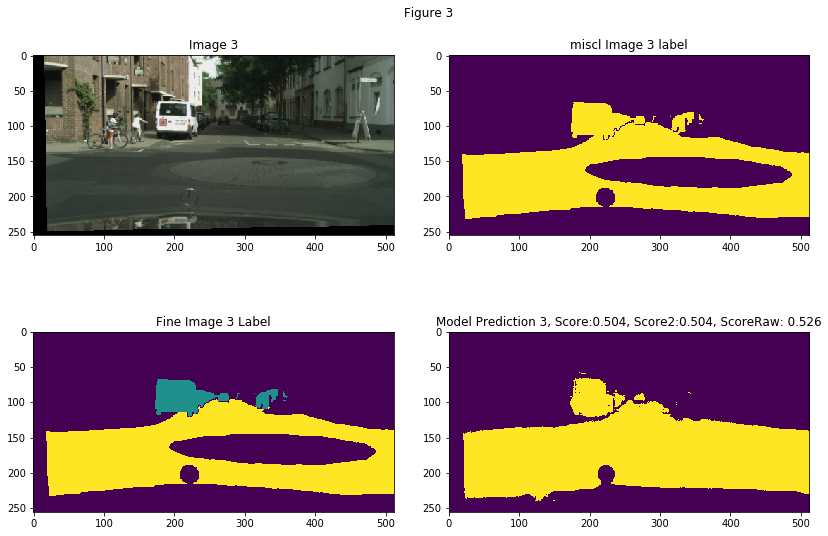

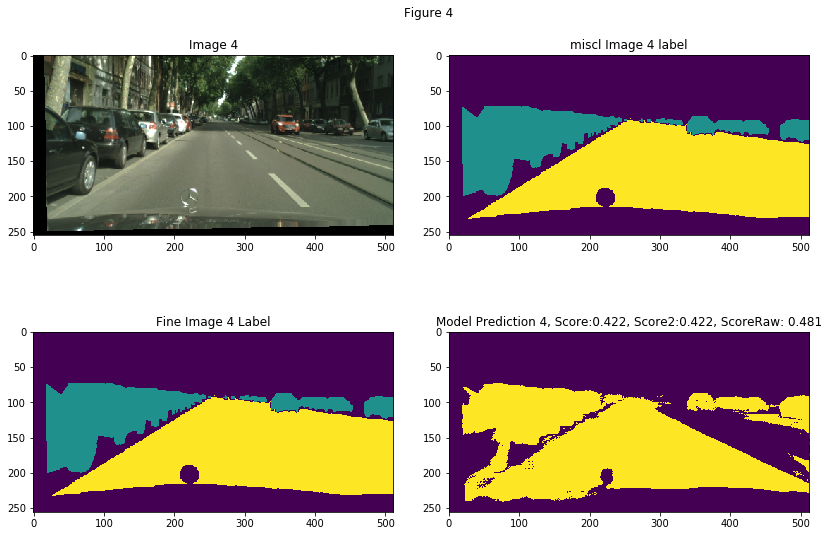

In [9]:
view_paired_predictions_on_training_data(coarse_model, ignore_pedestrians=ignore_pedestrians, coarse_or_miscl='miscl')

# Get Error-Correcting Model

In [10]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D, Lambda
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

input_window_size = 64
output_window_size = 1

# ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

lr_init = 1e-3
lr_decay = 5e-4

inp_y = Input(shape=(input_window_size, input_window_size, 3))
inp_x = Input(shape=(input_window_size, input_window_size, 3))

h = Concatenate()([inp_x, inp_y])
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(40, activation='relu')(h)
h = Dense(3, activation='softmax')(h)
h = Reshape((1, 1, 3))(h)
ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_x, inp_y])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
# h = Flatten()(h)
# h = Dense(40, activation='relu')(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

# h = Concatenate()([inp_y, inp_x])
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(inp_y)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
# h = MaxPool2D((2, 2), padding='same')(h)
# h = Flatten()(h)
# h = Dense(3, activation='softmax')(h)
# h = Reshape((1, 1, 3))(h)
# ec_model = Model(inputs=inp_y, outputs=h)

ec_model.summary()
metrics=['mean_squared_error', dice_coef]
ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                 loss='categorical_crossentropy', metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 64, 64, 6)    0           input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 8)    776         concatenate_9[0][0]              
__________

# Train EC Model 

In [122]:
test_get_ec_batch()

Test 1 passed
Test 2 passed
Test 3 passed


In [11]:
n_epochs = 5
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)
    print('\nEpoch {}, batch {}, Validation metrics (loss, mse, dice): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.0500962, 0.20983899, 0.36450136]
1 [0.903841, 0.17851384, 0.4706316]
2 [0.9377936, 0.17193733, 0.48383862]
3 [0.8414352, 0.1655936, 0.49142832]
4 [0.8209366, 0.15535678, 0.4860364]
5 [0.6570349, 0.11873174, 0.5771772]
6 [0.640403, 0.11805491, 0.61087275]
7 [0.5362685, 0.09671583, 0.67348576]
8 [0.56460917, 0.10673683, 0.687987]
9 [0.5745882, 0.11126659, 0.70615387]
10 [0.5542297, 0.09982467, 0.7259309]
11 [0.5608891, 0.09884253, 0.68885255]
12 [0.50518644, 0.09396907, 0.7029021]
13 [0.57682204, 0.10312449, 0.68701255]
14 [0.48484716, 0.089422174, 0.7115775]
15 [0.4849789, 0.0872906, 0.7552007]
16 [0.50714165, 0.09210296, 0.7377103]
17 [0.39048633, 0.0724549, 0.771335]
18 [0.47617856, 0.08712193, 0.7490419]
19 [0.659955, 0.11479692, 0.72254616]
20 [0.70016325, 0.11618755, 0.66700125]
21 [0.5762673, 0.09949279, 0.6964622]
22 [0.77384037, 0.12701963, 0.68833905]
23 [0.42104656, 0.07490127, 0.74140257]
24 [0.43359855, 0.07900108, 0.7396681]
25 [0.65887076, 0.1237133,

In [127]:
identity_model = get_identity_model()

In [123]:
val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)

x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=1,
    output_window_size=1, skip=12, diff=False)

500
500


In [128]:
metrics = identity_model.evaluate(y_val_coarse_batch, y_val_diff_batch)
metrics

30272/30272 [==============================] - 4s 124us/step


[0.2620284647492779, 0.049621046797330266, 0.8775234081276375]

# See Corrected Data (X, Y)

2975
2975
2975
2975


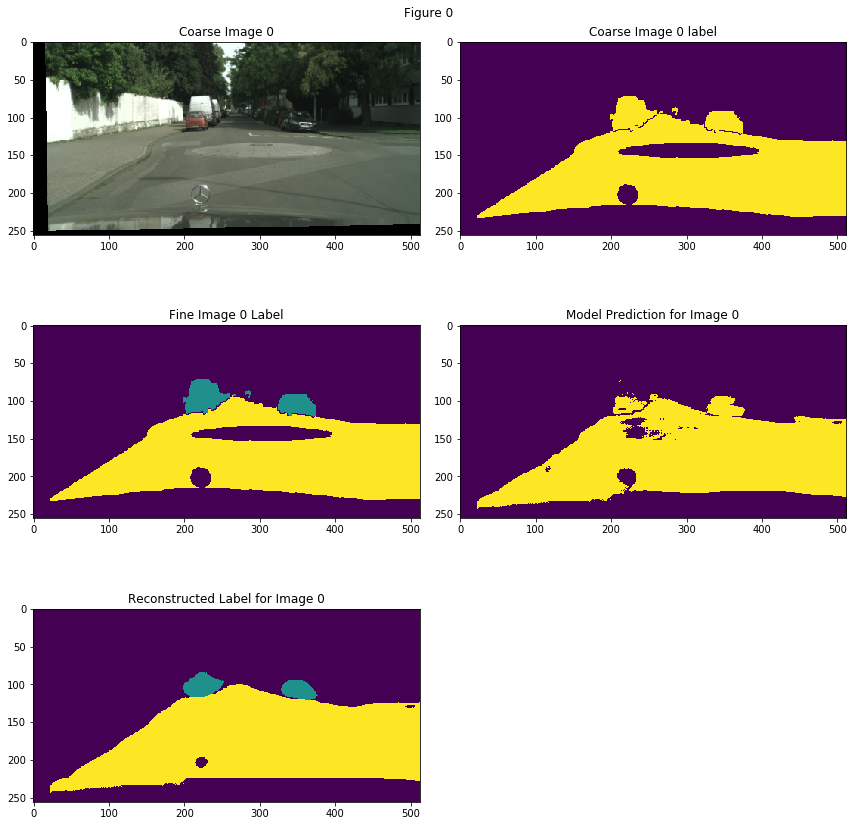

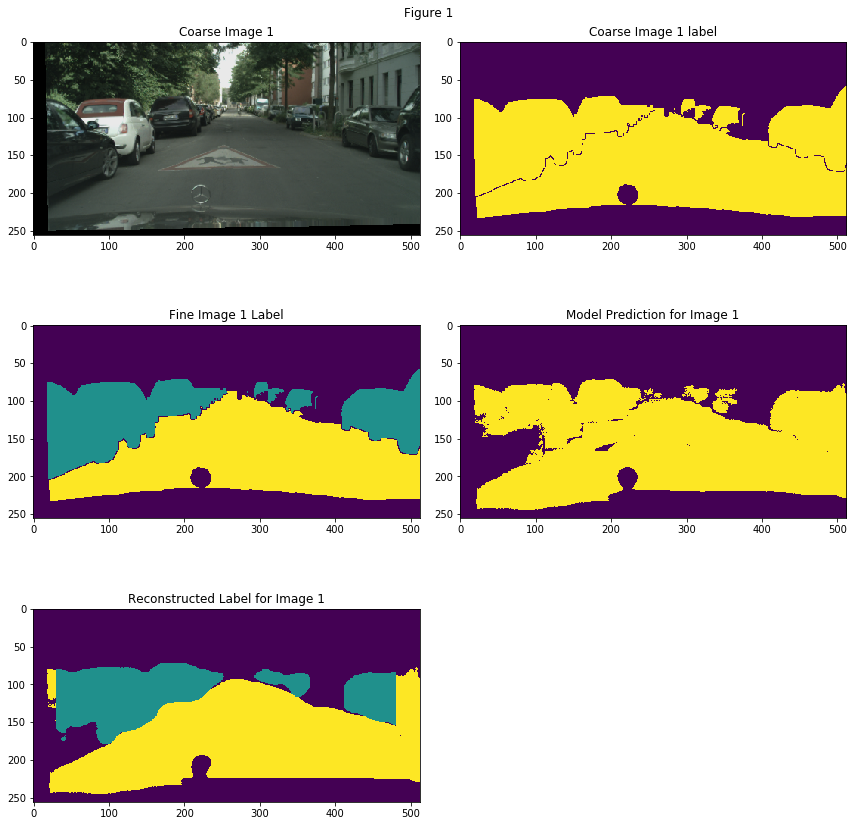

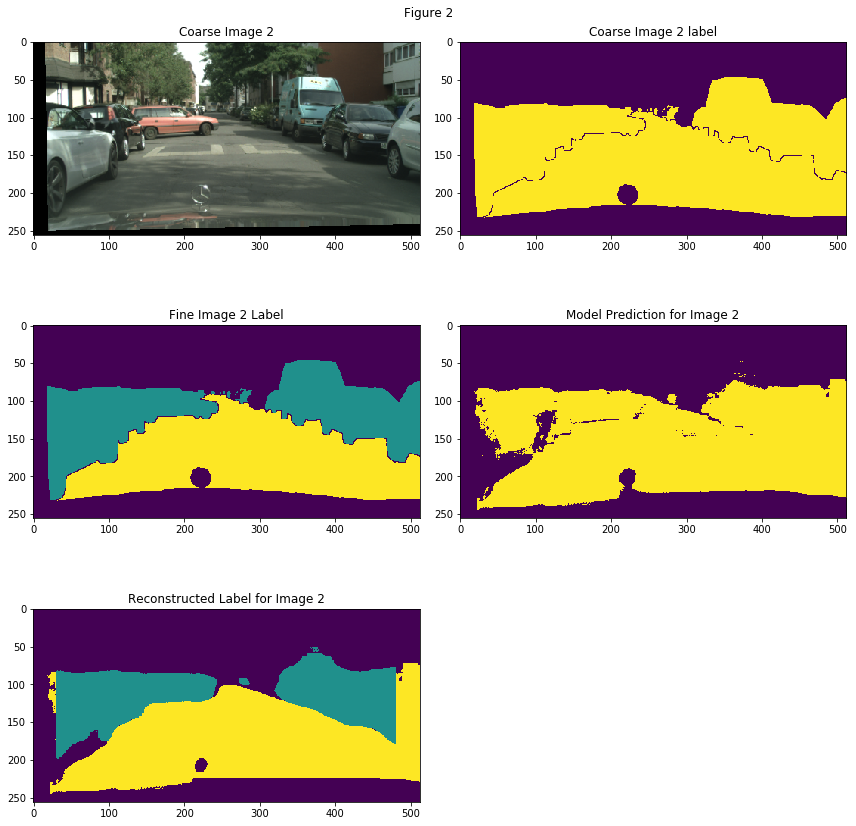

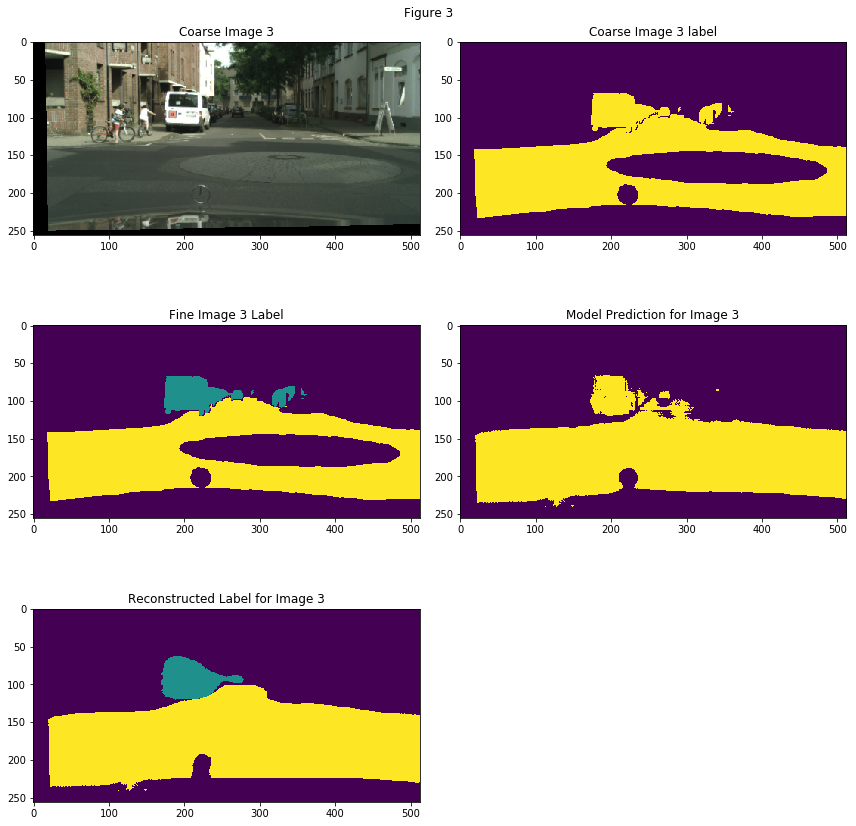

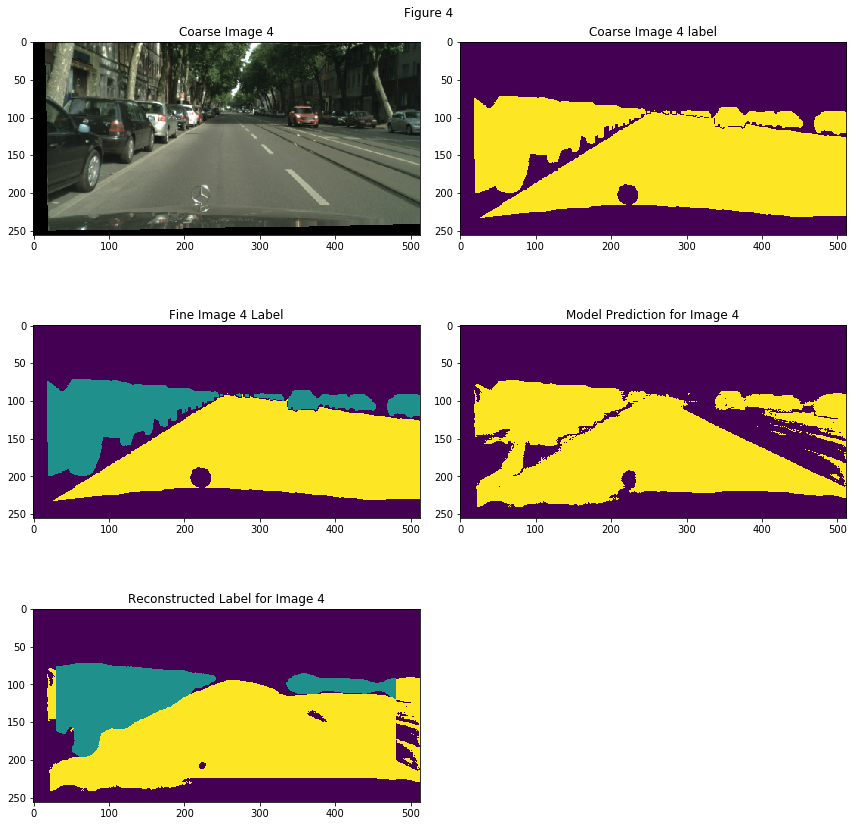

In [17]:
view_corrections_on_training_data(coarse_model, ec_model, n=5, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=True, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True, coarse_or_miscl='miscl')

2975
2975
2975


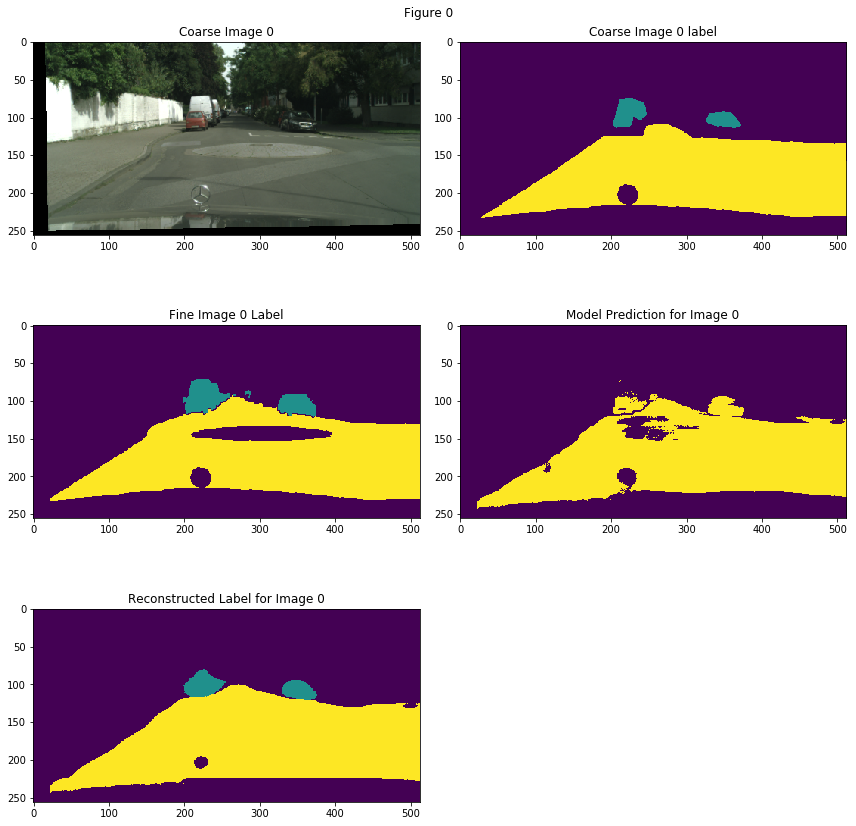

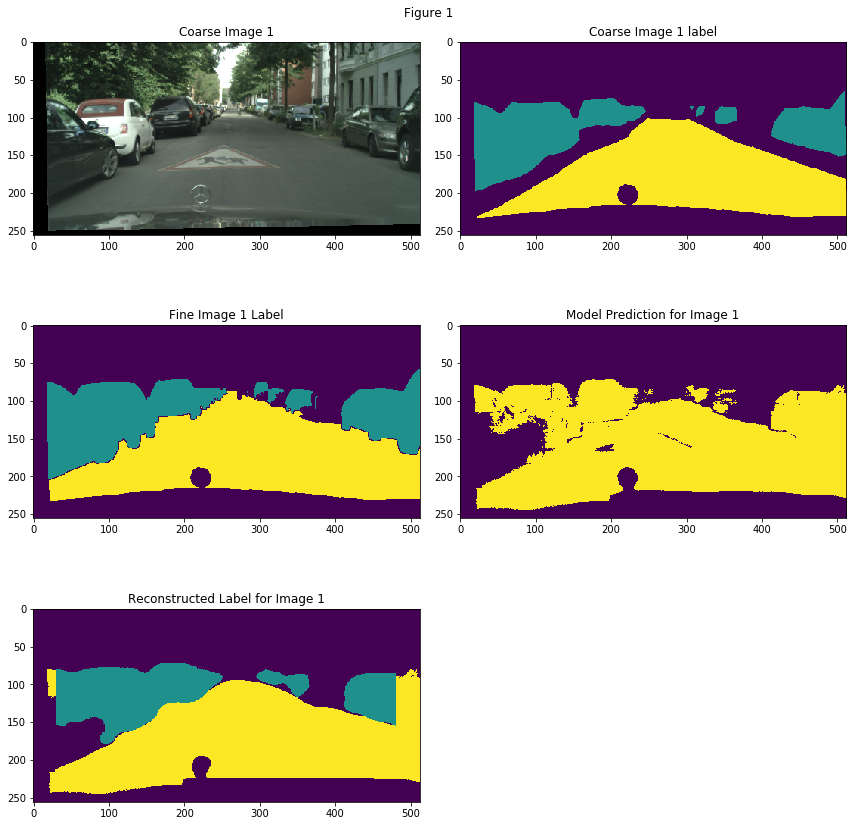

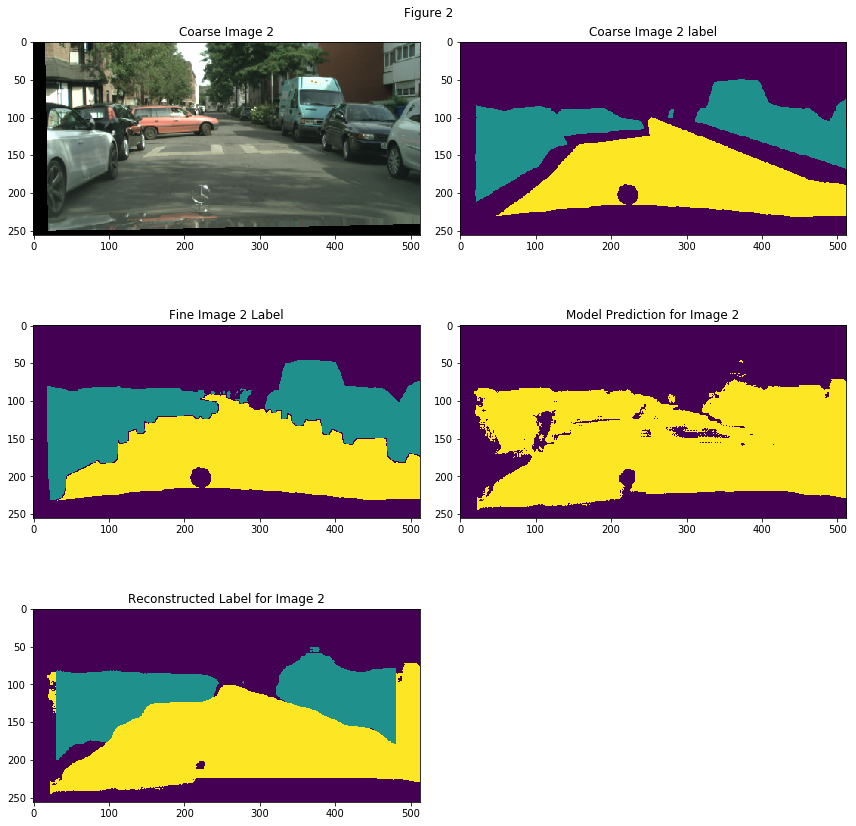

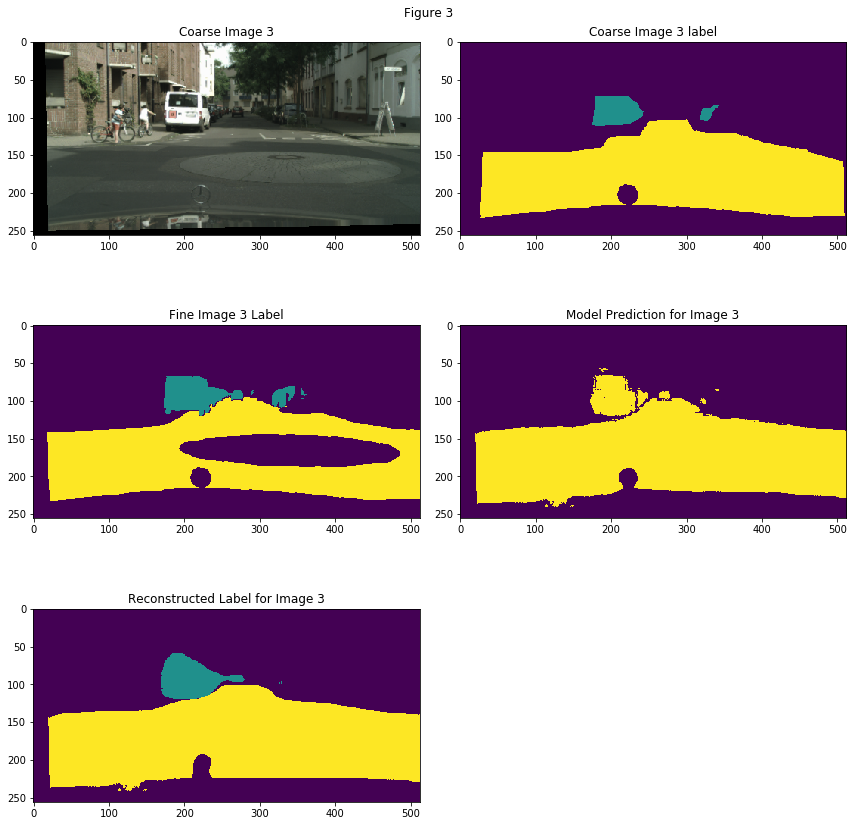

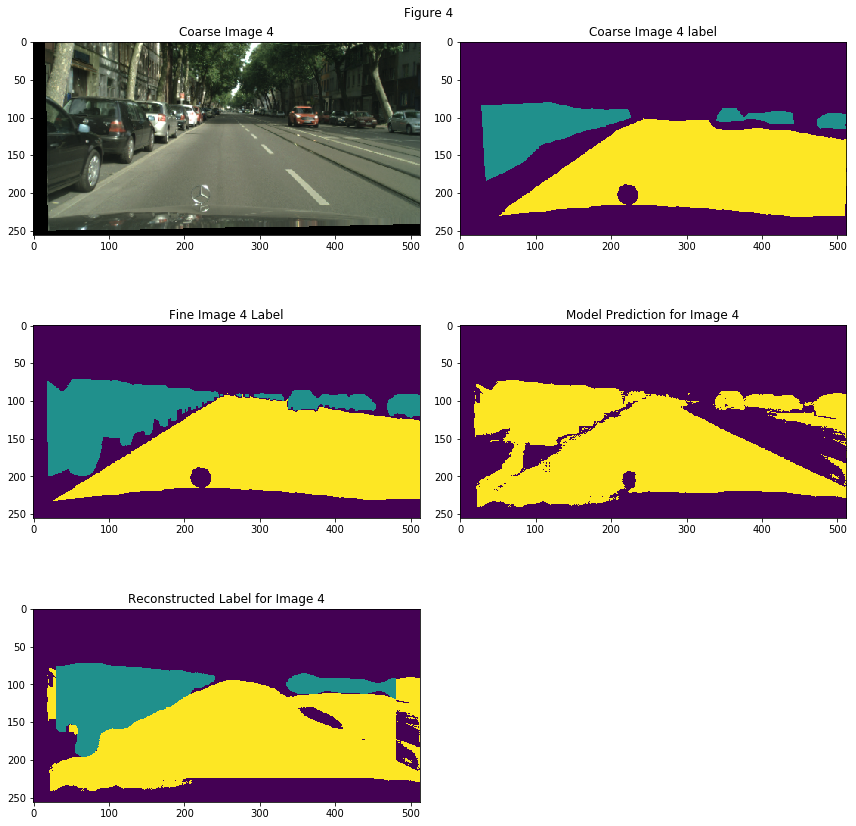

In [14]:
view_corrections_on_training_data(coarse_model, ec_model, n=5, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=True, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)